<a href="https://colab.research.google.com/github/Plavit/CIP-Geospatial-example/blob/main/CIP_DataScience_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code in Place Data Science Tutorial 2: Image and Geospatial manipulation
Author(s):
*   Marek Miltner, marek.miltner@stanford.edu


This tutorial provides a beginner-friendly introduction to Pillow, SimpleImage and image manipulation. It is meant to be worked through by a section leader.



<a name="software-requirements"></a>
# Software Requirements
The Python version at the time of this submission in Colab = Python 3.10.12

The following libraries are required:
*   pillow
*   simpleimage

In [ ]:
!python --version

Python 3.11.12


In [ ]:
!pip install pillow

In [ ]:
#@title Simple Image Library

#!/usr/bin/env python3

"""
Stanford CS106AP SimpleImage

Written by Nick Parlante, Sonja Johnson-Yu, and Nick Bowman.
Adapted for Colab by Marek Miltner
 -7/2019  version, has file reading, pix, foreach, hidden get/setpix
 -6/2024  adaptation to Colab
SimpleImage Features:
Create image:
  image = SimpleImage.blank(400, 200)   # create new image of size
  image = SimpleImage('foo.jpg')        # create from file

Access size
  image.width, image.height

Get pixel at x,y
  pix = image.get_pixel(x, y)
  # pix is RGB tuple like (100, 200, 0)

Set pixel at x,y
  image.set_pixel(x, y, pix)   # set data by tuple also

Get Pixel object at x,y
  pixel = image.get_pixel(x, y)
  pixel.red = 0
  pixel.blue = 255

Show image on screen
  image.show()

The main() function below demonstrates the above functions as a test.
"""

import sys
# If the following line fails, "Pillow" needs to be installed
from PIL import Image


def clamp(num):
    """
    Return a "clamped" version of the given num,
    converted to be an int limited to the range 0..255 for 1 byte.
    """
    num = int(num)
    if num < 0:
        return 0
    if num >= 256:
        return 255
    return num


class Pixel(object):
    """
    A pixel at an x,y in a SimpleImage.
    Supports set/get .red .green .blue
    and get .x .y
    """
    def __init__(self, image, x, y):
        self.image = image
        self._x = x
        self._y = y

    def __str__(self):
        return 'r:' + str(self.red) + ' g:' + str(self.green) + ' b:' + str(self.blue)

    # Pillow image stores each pixel color as a (red, green, blue) tuple.
    # So the functions below have to unpack/repack the tuple to change anything.

    @property
    def red(self):
        return self.image.px[self._x, self._y][0]

    @red.setter
    def red(self, value):
        rgb = self.image.px[self._x, self._y]
        self.image.px[self._x, self._y] = (clamp(value), rgb[1], rgb[2])

    @property
    def green(self):
        return self.image.px[self._x, self._y][1]

    @green.setter
    def green(self, value):
        rgb = self.image.px[self._x, self._y]
        self.image.px[self._x, self._y] = (rgb[0], clamp(value), rgb[2])

    @property
    def blue(self):
        return self.image.px[self._x, self._y][2]

    @blue.setter
    def blue(self, value):
        rgb = self.image.px[self._x, self._y]
        self.image.px[self._x, self._y] = (rgb[0], rgb[1], clamp(value))

    @property
    def x(self):
        return self._x

    @property
    def y(self):
        return self._y


# color tuples for background color names 'red' 'white' etc.
BACK_COLORS = {
    'white': (255, 255, 255),
    'black': (0, 0, 0),
    'red': (255, 0, 0),
    'green': (0, 255, 0),
    'blue': (0, 0, 255),
}


class SimpleImage(object):
    def __init__(self, filename, width=0, height=0, back_color=None):
        """
        Create a new image. This case works: SimpleImage('foo.jpg')
        To create a blank image use SimpleImage.blank(500, 300)
        The other parameters here are for internal/experimental use.
        """
        # Create pil_image either from file, or making blank
        if filename:
            self.pil_image = Image.open(filename).convert("RGB")
            if self.pil_image.mode != 'RGB':
                raise Exception('Image file is not RGB')
            self._filename = filename  # hold onto
        else:
            if not back_color:
                back_color = 'white'
            color_tuple = BACK_COLORS[back_color]
            if width == 0 or height == 0:
                raise Exception('Creating blank image requires width/height but got {} {}'
                                .format(width, height))
            self.pil_image = Image.new('RGB', (width, height), color_tuple)
        self.px = self.pil_image.load()
        size = self.pil_image.size
        self._width = size[0]
        self._height = size[1]
        self.curr_x = 0
        self.curr_y = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.curr_x < self.width and self.curr_y < self.height:
            x = self.curr_x
            y = self.curr_y
            self.increment_curr_counters()
            return Pixel(self, x, y)
        else:
            self.curr_x = 0
            self.curr_y = 0
            raise StopIteration()

    def increment_curr_counters(self):
        self.curr_x += 1
        if self.curr_x == self.width:
            self.curr_x = 0
            self.curr_y += 1

    @classmethod
    def blank(cls, width, height, back_color=None):
        """Create a new blank image of the given width and height, optional back_color."""
        return SimpleImage('', width, height, back_color=back_color)

    @classmethod
    def file(cls, filename):
        """Create a new image based on a file, alternative to raw constructor."""
        return SimpleImage(filename)

    @property
    def width(self):
        """Width of image in pixels."""
        return self._width

    @property
    def height(self):
        """Height of image in pixels."""
        return self._height

    def get_pixel(self, x, y):
        """
        Returns a Pixel at the given x,y, suitable for getting/setting
        .red .green .blue values.
        """
        if x < 0 or x >= self._width or y < 0 or y >= self.height:
            e = Exception('get_pixel bad coordinate x %d y %d (vs. image width %d height %d)' %
                          (x, y, self._width, self.height))
            raise e
        return Pixel(self, x, y)

    def set_pixel(self, x, y, pixel):
        if x < 0 or x >= self._width or y < 0 or y >= self.height:
            e = Exception('set_pixel bad coordinate x %d y %d (vs. image width %d height %d)' %
                          (x, y, self._width, self.height))
            raise e
        self.px[x, y] = (pixel.red, pixel.green, pixel.blue)

    def set_rgb(self, x, y, red, green, blue):
        """
        Set the pixel at the given x,y to have
        the given red/green/blue values without
        requiring a separate pixel object.
        """
        self.px[x, y] = (red, green, blue)

    def _get_pix_(self, x, y):
        """Get pix RGB tuple (200, 100, 50) for the given x,y."""
        return self.px[x, y]

    def _set_pix_(self, x, y, pix):
        """Set the given pix RGB tuple into the image at the given x,y."""
        self.px[x, y] = pix

    def show(self):
        """Displays the image using an external utility."""
        #self.pil_image.show()
        display(self.pil_image)

    def make_as_big_as(self, image):
        """Resizes image to the shape of the given image"""
        self.pil_image = self.pil_image.resize((image.width, image.height))
        self.px = self.pil_image.load()
        size = self.pil_image.size
        self._width = size[0]
        self._height = size[1]


In [ ]:
from google.colab import files as FILE
import os
import requests
import urllib.request
from PIL import Image
from pathlib import Path


urllib.request.urlretrieve(
    'https://images.fineartamerica.com/images-medium-large-5/san-francisco-bay-nasascience-photo-library.jpg',
    'bay.jpg')
img=Image.open('bay.jpg')
new_height = 680
new_width  = int(new_height * img.width / img.height)
img = img.resize((new_width, new_height), Image.LANCZOS)
#display(img)
img.save("bay.jpg")


urllib.request.urlretrieve(
    'https://s3-us-west-2.amazonaws.com/stanford-125/wp-content/uploads/2015/12/MainQuadChurch-2048x1365.jpg',
    'quad.jpg')
img=Image.open('quad.jpg')
new_height = 400
new_width  = int(new_height * img.width / img.height)
img = img.resize((new_width, new_height), Image.LANCZOS)
#display(img)
img.save("quad.jpg")

urllib.request.urlretrieve(
    'https://grist.org/wp-content/uploads/2017/08/greenland-wildfire1.jpg',
    'fires.jpg')
img=Image.open('fires.jpg')
new_height = 1000
new_width  = int(new_height * img.width / img.height)
img = img.resize((new_width, new_height), Image.LANCZOS)
img=img.crop((400, 300, 1250, 700))
#display(img)
img.save("fires.jpg")



# Black and White Filter
Let's try and create a black and white effect in Pillow

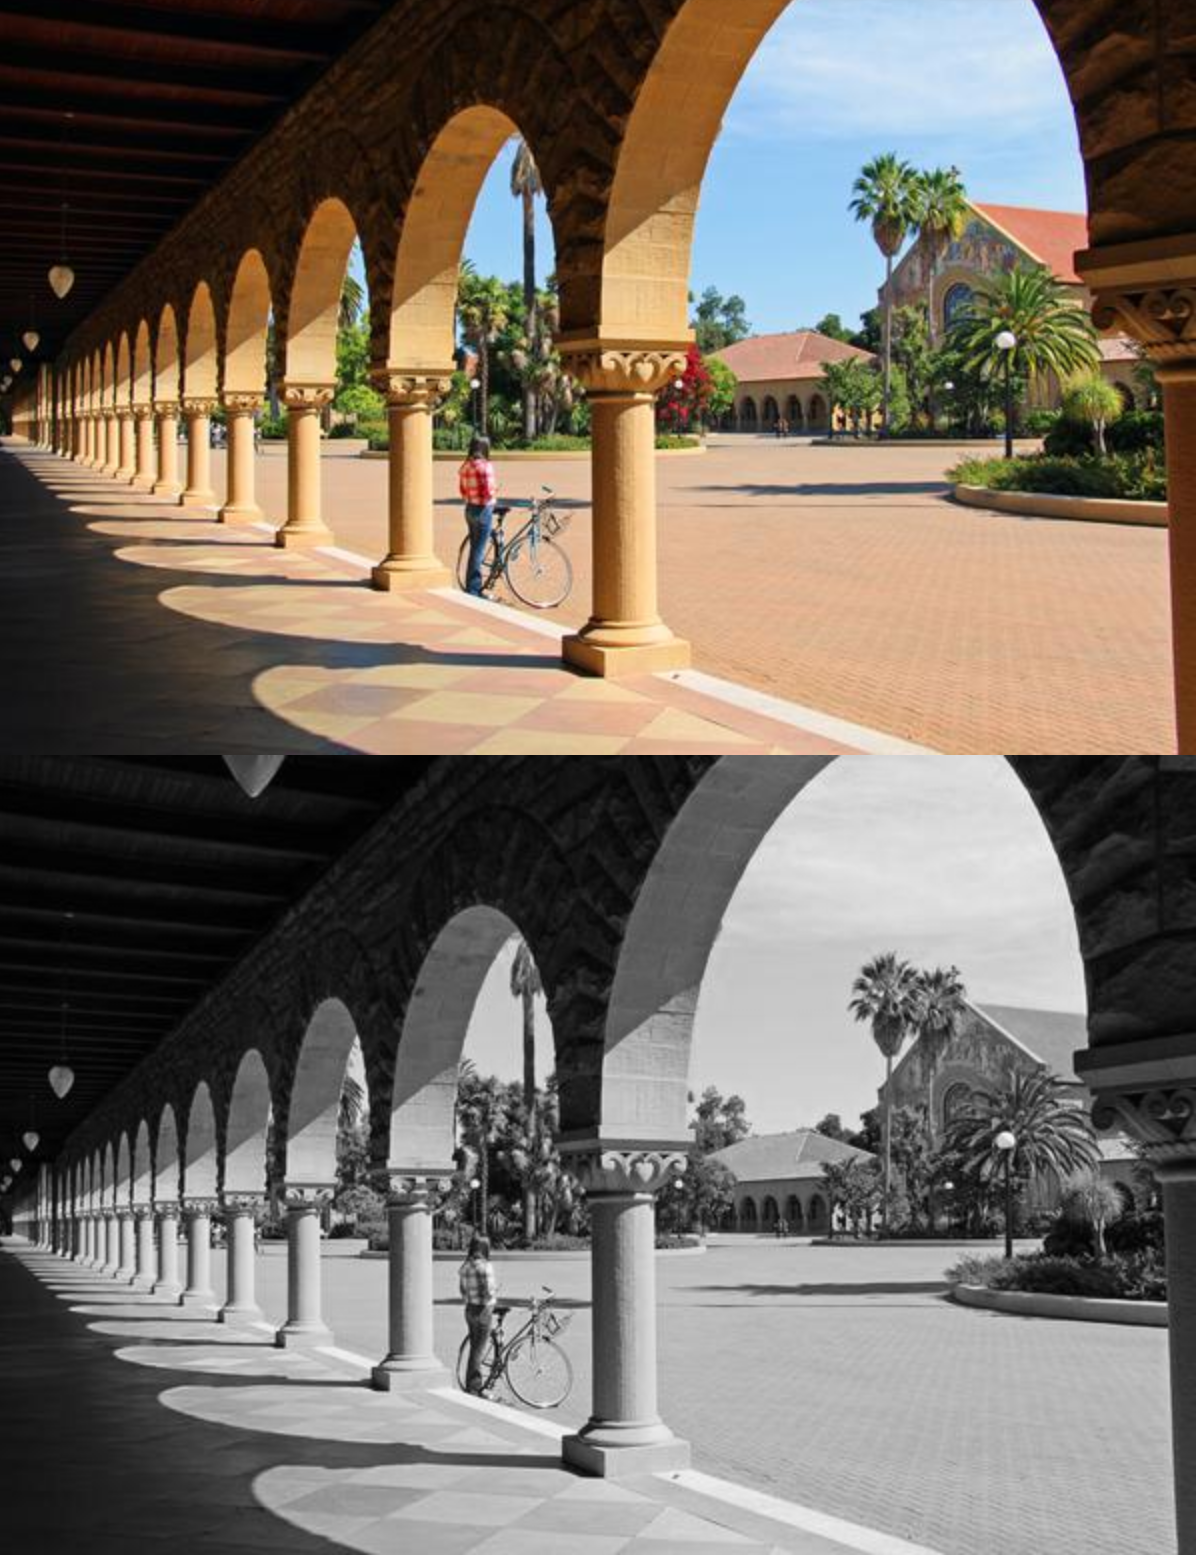

In [ ]:
from PIL import Image

DEFAULT_FILE = 'quad.jpg'

def main():
    # Get file and load image
    filename = DEFAULT_FILE
    image = SimpleImage(filename)

    # Show the image before the transform
    image.show()

    # Apply the filter
    # TODO: your code here


    # Show the image after the transform
    display(image.pil_image)



if __name__ == '__main__':
    main()

NameError: name 'SimpleImage' is not defined

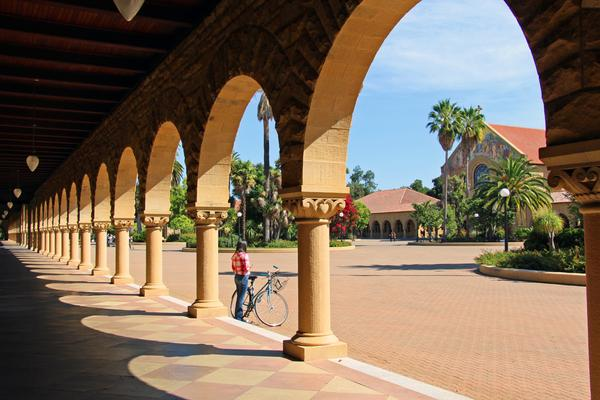

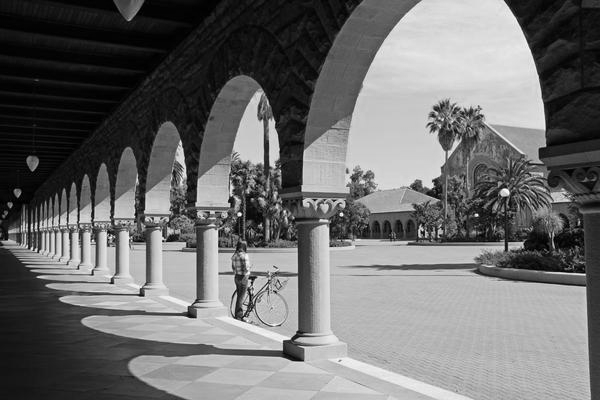

In [ ]:
#@title Solution
from PIL import Image

DEFAULT_FILE = 'quad.jpg'

def main():
    # Get file and load image
    filename = DEFAULT_FILE
    image = SimpleImage(filename)

    # Show the image before the transform
    image.show()

    # Apply the filter
    # TODO: your code here
    for px_w in range(image.width):
      for px_h in range(image.height):
        px=image.get_pixel(px_w,px_h)
        avg=int((px.red+px.green+px.blue)/3)
        image.set_rgb(px_w,px_h,avg,avg,avg)

    # Show the image after the transform
    display(image.pil_image)



if __name__ == '__main__':
    main()

# Finding Forest Flames

We’re going to start by writing a function called find_flames  that
highlights the areas where a forest fire is active. You’re given a satellite image of
Greenland’s 2017 fires (photo credit: Stef Lhermitte, Delft University of Technology).
Your job is to detect all of the “sufficiently red” pixels in the image, which are indicative
of where fires are burning in the image. As we did in class with the “redscreening”
example, we consider a pixel “sufficiently red” if its red value is greater than or equal to
the average of the pixel’s three RGB values.

When you detect a “sufficiently red” pixel in the original image, you set its red value to
255 and its green and blue values to 0. This will highlight the pixel by making it entirely
red. For all other pixels (i.e., those that are not “sufficiently red”), you should convert
them to their grayscale equivalent, so that we can more easily see where the fire is
originating from. You can grayscale a pixel by summing together its red, green, and blue
values and dividing by three (finding the average), and then setting the pixel’s red, green,
and blue values to all have this same “average” value.

Once you highlight the areas that are on fire in the image (and greyscale all the remaining
pixels), you should see an image like that shown on the right in the image bellow. On the
left side of Figure 1, we should the original image for comparison.

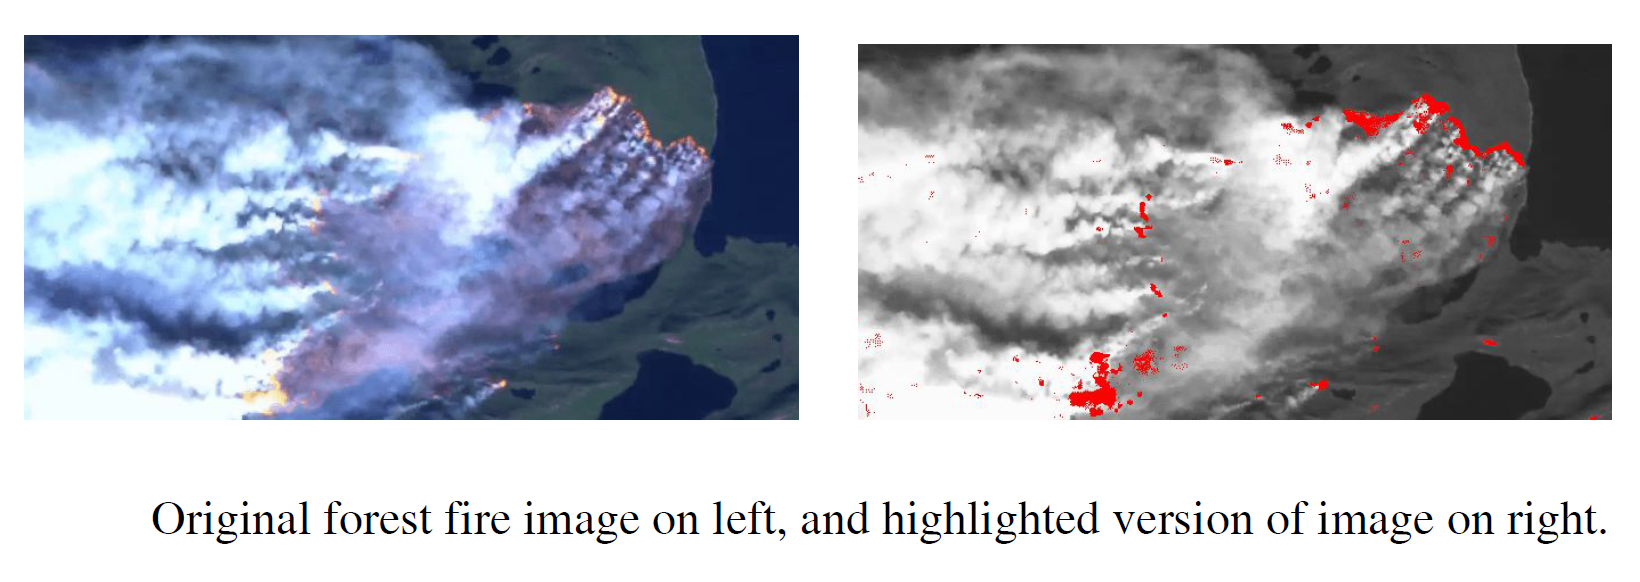

In [ ]:
DEFAULT_FILE = 'fires.jpg'

def find_flames(filename):
    """
    This function should highlight the "sufficiently red" pixels
    in the image and grayscale all other pixels in the image
    in order to highlight areas of wildfires.
    """
    image = SimpleImage(filename)
    # TODO: your code here
    return image

def main():
    # Get file and load image
    filename = DEFAULT_FILE
    image = SimpleImage(filename)

    # Show the original fire
    original_fire = SimpleImage(filename)
    original_fire.show()

    # Show the highlighted fire
    highlighted_fire = find_flames(filename)
    highlighted_fire.show()

if __name__ == '__main__':
    main()

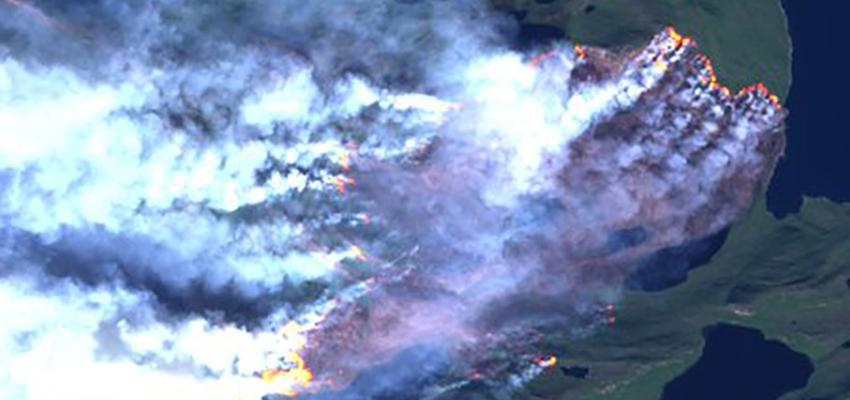

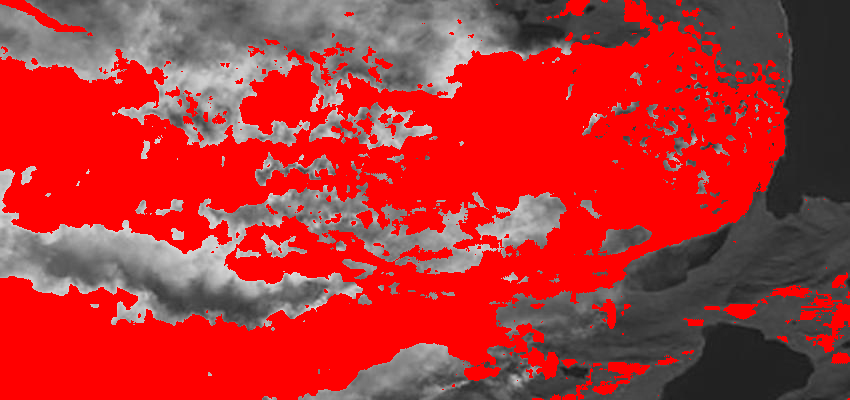

In [ ]:
#@title Solution Forest Fires
DEFAULT_FILE = 'fires.jpg'

def find_flames(filename):
    """
    This function should highlight the "sufficiently red" pixels
    in the image and grayscale all other pixels in the image
    in order to highlight areas of wildfires.
    """
    image = SimpleImage(filename)
    # TODO: your code here
    for px in image:
      avg=int((px.red+px.green+px.blue)/3)
      if px.red>avg*0.8:
        image.set_rgb(px.x,px.y,255,0,0)
      else:
        image.set_rgb(px.x,px.y,avg,avg,avg)

    return image

def main():
    # Get file and load image
    filename = DEFAULT_FILE
    image = SimpleImage(filename)

    # Show the original fire
    original_fire = SimpleImage(filename)
    original_fire.show()

    # Show the highlighted fire
    highlighted_fire = find_flames(filename)
    highlighted_fire.show()

if __name__ == '__main__':
    main()